# Workshop 02: Extreme Value Analysis

**Solution.**

In this workshop, you will jump into an engineering problem to apply Extreme Value Analysis (EVA) to the design of a structure against wave loading. To do so, we will use wave data in the North sea extracted from ERA5 database. [ERA5 database](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) is based on reanalysis (a combination of model data and observations), allowing to have data for more than 60 years. 

But let's go back to our analysis. First things first, let's import the packages we will need to address this workshop. Here it is our suggestion, but feel free to add any packages you may need.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.signal import find_peaks
import datetime
%matplotlib inline
from dispersion_index import DI_plot

The first step in the design is to determine the loading that our structure needs to withstand according to the applicable regulations and recommendations. According to them, our structure needs to be designed for a **design life of 50 years** and a **failure probability along the design life of 0.1**. 

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
    
<b>Task 1:</b>
Calculate the design return period. Round it to an integer number for the shake of simplicity.
</p>
</div>

In [26]:
RT_Binomial = 1/(1-(1-0.1)**(1/50))
RT_Poisson = -50/np.log(1-0.1)
print(f'The return period calculated with the Binomial approximation is: {RT_Binomial:.0f}')
print(f'The return period calculated with the Poisson approximation is: {RT_Poisson:.0f}')

The return period calculated with the Binomial approximation is: 475
The return period calculated with the Poisson approximation is: 475


<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
    <b>Solution 1:</b>
    
When the value of the number of trials in a Binomial distribution is large and the value of p (exceedance
probability here) is very small,the binomial distribution can be approximated by a Poisson distribution.
Thus, no significant differences are obtained.

We will adopt a design return period of 475 years.</p>
</div>

Now that we know the design return period, let's start with the analysis of our wave data. Choose one of the provided datasets and import it using the code below. Note that you will have to change the name of the file depending on the selected dataset.

In [5]:
pandas = pd.read_csv('Time_Series_DEN_lon_8_lat_56.5_ERA5.txt', delimiter=r"\s+", 
                     names=['date_&_time', 
                            'significant_wave_height_(m)', 
                            'mean_wave_period_(s)', 
                            'Peak_wave_Period_(s)', 
                            'mean_wave_direction_(deg_N)', 
                            '10_meter_wind_speed_(m/s)', 
                            'Wind_direction_(deg_N)'],  # custom header names
                     skiprows=1)  # Skip the initial row (header)


We will change the format of the time stamp and start taking looking how our data looks. Ensure you know what it is in each column of the dataframe.

In [6]:
pandas['date_&_time'] = pd.to_datetime(pandas['date_&_time']-719529, unit='D')

# The value 719529 is the datenum value of the Unix epoch start (1970-01-01), 
# which is the default origin for pd.to_datetime().

pandas.head()

,date_&_time,significant_wave_height_(m),mean_wave_period_(s),Peak_wave_Period_(s),mean_wave_direction_(deg_N),10_meter_wind_speed_(m/s),Wind_direction_(deg_N)
0,1950-01-01 00:00:00.000000000,1.274487,4.493986,5.177955,199.731575,8.582743,211.166241
1,1950-01-01 04:00:00.000026880,1.338850,4.609748,5.255064,214.679306,8.867638,226.280409
2,1950-01-01 07:59:59.999973120,1.407454,4.775651,5.390620,225.182820,9.423382,230.283209
3,1950-01-01 12:00:00.000000000,1.387721,4.800286,5.451532,227.100041,9.037646,238.879880
4,1950-01-01 16:00:00.000026880,1.660848,5.112471,5.772289,244.821975,10.187995,242.554054


<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
    
<b>Task 2:</b>
Plot the wave height time series. 
</p>
</div>

Text(0, 0.5, '${H_s (m)}$')

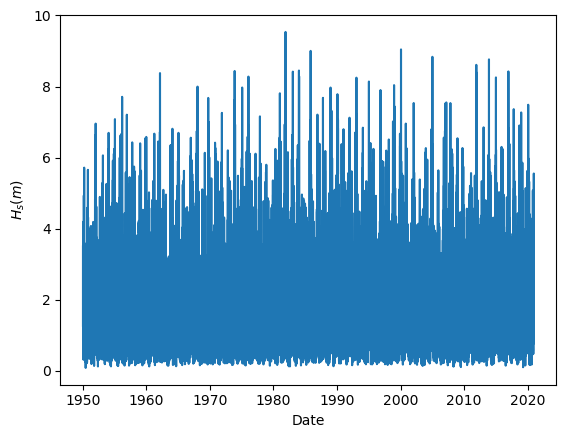

In [7]:
plt.figure(1, facecolor='white')
plt.plot(pandas['date_&_time'], pandas['significant_wave_height_(m)'])
plt.xlabel('Date')
plt.ylabel('${H_s (m)}$')

It is always good practice to have a look to our data, since it is the simplest way to start detecting 
possible outliers or error measurements. For instance, when working with data coming from buoys, a extremely high
or low number (such as 9999 or -9999) is recorded when the buoy is not able to measure. That way error measurements
can be easily removed before our analysis.

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
    
<b>Task 3:</b>
Calculate the basic descriptive statistics. What can you conclude from them?
</p>
</div>

In [8]:
pandas.describe()

,date_&_time,significant_wave_height_(m),mean_wave_period_(s),Peak_wave_Period_(s),mean_wave_direction_(deg_N),10_meter_wind_speed_(m/s),Wind_direction_(deg_N)
count,155598,155598.000000,155598.000000,155598.000000,155598.000000,155598.000000,155598.000000
mean,1985-07-02 10:00:00,1.590250,5.634407,6.636580,232.701281,8.319785,204.579953
min,1950-01-01 00:00:00,0.085527,2.331908,1.826027,0.000001,0.337945,0.013887
25%,1967-10-02 05:00:00.000013408,0.845189,4.691991,5.280570,195.018128,5.749446,125.038362
50%,1985-07-02 09:59:59.999986560,1.343157,5.493290,6.347569,257.075066,8.063807,221.875462
75%,2003-04-02 15:00:00.000020224,2.072028,6.442927,7.606390,303.985158,10.585083,286.772466
max,2020-12-31 19:59:59.999973120,9.537492,13.610824,21.223437,359.985729,28.536715,359.997194
std,NaN,1.025524,1.292642,2.034652,88.523561,3.449235,93.936119


<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
     <b>Solution 3:</b>
Another extra step which helps to have a sense on how our data looks like, it is the basic statistical
descriptors. Here, we can see that the ranges (min, max) of the variables are reasonable, as well as their mean
values. This is an indication that our data is reasonably clean and there are not measurement errors.
 </p>
</div>

In the following code, we are selecting the dominant wave direction. To do so, we select the values of the wave height above the 99% percentile (we are interested in the highest values) and select the range of directions corresponding to those observations. The resulting selection is stored in a new pandas dataframe names '*pandas_angle*'. The process is illustrated in the plots.

5.003667620267622


(0.0, 350.0)

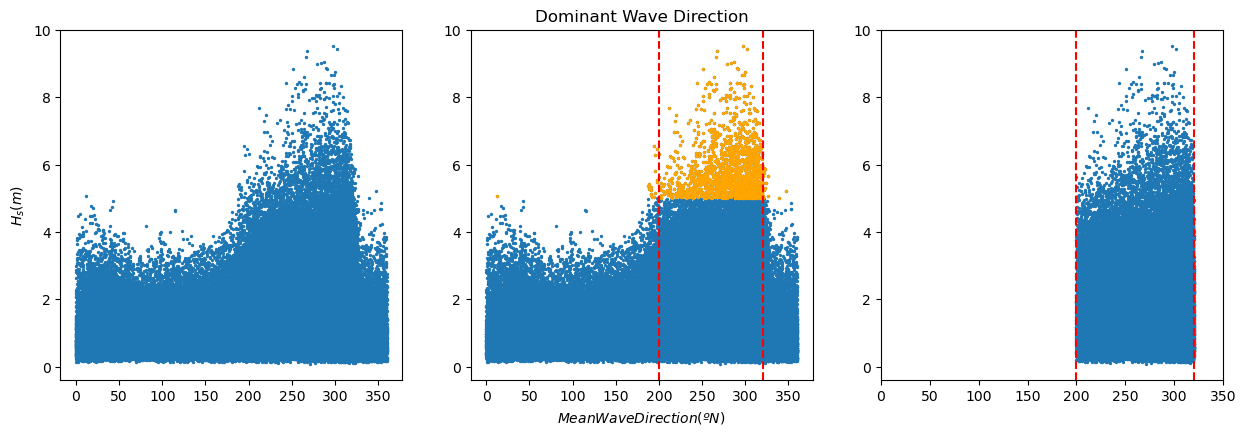

In [9]:
plt.figure(2, figsize = (15,10), facecolor='white')

plt.subplot(2,3,1)
plt.scatter(pandas['mean_wave_direction_(deg_N)'], pandas['significant_wave_height_(m)'], s = 2)
plt.ylabel('${H_s (m)}$')

print(pandas['significant_wave_height_(m)'].quantile(0.99))
pandas_99 = pandas[pandas['significant_wave_height_(m)']>=pandas['significant_wave_height_(m)'].quantile(0.99)]

plt.subplot(2,3,2)
plt.title('Dominant Wave Direction')
plt.scatter(pandas['mean_wave_direction_(deg_N)'], pandas['significant_wave_height_(m)'], s = 2)
plt.scatter(pandas_99['mean_wave_direction_(deg_N)'], pandas_99['significant_wave_height_(m)'], color='orange', s = 2)
plt.axvline(x = 200, color = 'r', linestyle = 'dashed')
plt.axvline(x = 320, color = 'r', linestyle = 'dashed')
plt.xlabel('$Mean Wave Direction (ºN)$')


pandas_angle = pandas[(pandas['mean_wave_direction_(deg_N)'].between(200, 320))]

plt.subplot(2,3,3)
plt.scatter(pandas_angle['mean_wave_direction_(deg_N)'], pandas_angle['significant_wave_height_(m)'], s = 2)
plt.axvline(x = 200, color = 'r', linestyle = 'dashed')
plt.axvline(x = 320, color = 'r', linestyle = 'dashed')
plt.xlim([0, 350])

In the following code, first, we compute the wave length and wave steepness of each observation. After that, we plot the wave height against the wave period highlighting those values of the wave height above the 99% percentile, and draw the lines of constant wave steepness (quotient between the wave height and the wave length).

C:\Users\rlanzafame\AppData\Local\Temp\ipykernel_23664\3757055316.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  L[iL,jL] =  L0[jL]*np.tanh(2*np.pi*(Depth/(L[iL-1,jL])))


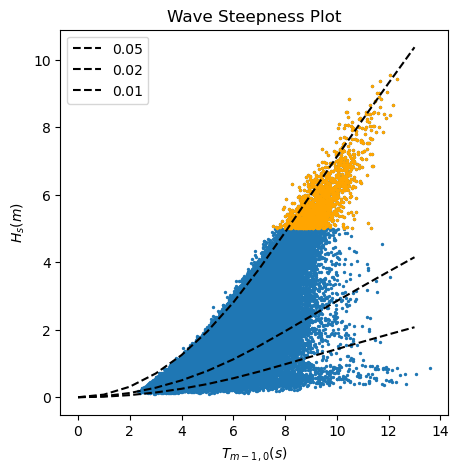

In [10]:
#Calculate theoretical wave steepness lines following the wave dispersion relationship.
N = 15
iterations = 20
Depth = 35
T_p = np.linspace(0,N,N+1)
L0 = 9.81*(T_p**2)/(2*np.pi) # Deep water wave length
L = np.zeros((iterations,len(T_p)))
L[0,:] = L0                # Initial guess for wave length = deep water wave length
L[0,0] = 0.1

# Calculate the wave periods using an iterative approach
for iL in np.arange(1,(len(L[:,0]))):
    for jL in np.arange(0,len(T_p)):
        L[iL,jL] =  L0[jL]*np.tanh(2*np.pi*(Depth/(L[iL-1,jL])))

# Compute theoretical significant wave heights for different steepnesses
Hs005 = L[-1,:]*0.05;
Hs002 = L[-1,:]*0.02;
Hs001 = L[-1,:]*0.01;

plt.figure(3, figsize = (5,5), facecolor='white')
plt.scatter(pandas['mean_wave_period_(s)'], pandas['significant_wave_height_(m)'], s = 2)
plt.scatter(pandas_99['mean_wave_period_(s)'], pandas_99['significant_wave_height_(m)'], color='orange', s = 2)
plt.plot(T_p[:-2], Hs005[:-2], linestyle = 'dashed', color = 'black', label = 0.05)
plt.plot(T_p[:-2], Hs002[:-2], linestyle = 'dashed', color = 'black', label = 0.02)
plt.plot(T_p[:-2], Hs001[:-2], linestyle = 'dashed', color = 'black', label = 0.01)
plt.xlabel('${T_{m-1,0} (s)}$')
plt.ylabel('${H_s (m)}$')
plt.title('Wave Steepness Plot')
plt.legend()

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
    
<b>Task 4:</b>
Based on the results of the two previous analysis, which data should we consider for our EVA? Why?
</p>
</div>

<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
    
<b>Solution 4:</b>
    
First analysis, wave height and mean wave direction: When working with wave data, we need to ensure that we are 
considering waves generated by the same drivers, so it is the same statistical population. For instance, in a given
location in the coast, we may have summer storms coming from the North and storms coming from the East during the
fall. Both of them will generate extreme observations, but we need to study them independently, since their
characteristics are different.

Second analysis, wave height and wave period: Swell waves are those generated by wind in the far field and
propagated through long distances towards the coast, although they may not be sustained by wind anymore. Swell waves
are usually linked to longer wave periods and, thus,lower values of the wave steepness. On the other hand, locally
generated sea waves are usually characterized by short wave periods and higher values of wave steepness. In order
to consider waves that are generated by the same drivers, we need to separate waves with very different wave steepness.

In the plot above, we can see that the waves over the 99% percentiles present a similar low value of the wave
steepness, being then swell waves. Therefore, we can use for our EVA analysis those waves coming with a mean wave 
angle between 200 and 320 already selected in the dataframe pandas_angle.
 </p>
</div>

Use the dataframe '*pandas_angle*' for the following steps. 

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
    
<b>Task 5:</b>
Apply Yearly Maxima to sample the extreme observations. Plot the results.
</p>
</div>

Text(0, 0.5, '${H_s (m)}$')

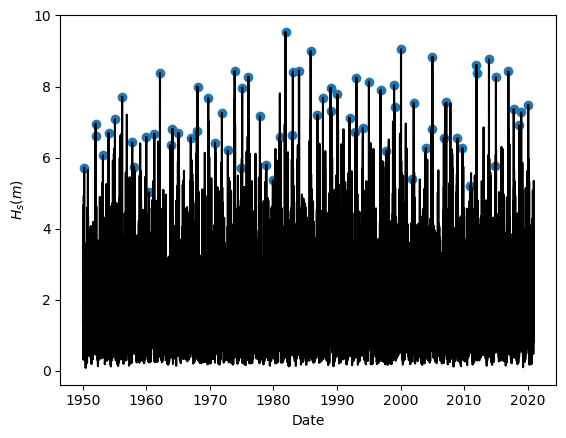

In [11]:
#Function definition
def yearly_maxima(data):
    max_list = pd.DataFrame(columns=data.columns)
    for i in pd.DatetimeIndex(data['date_&_time']).year.unique():
        one_year_value=data[data['date_&_time'].dt.year == i]
        one_year_value_pos=one_year_value['significant_wave_height_(m)'].idxmax()
        one_year_value_DF=one_year_value.loc[[one_year_value_pos]]
        max_list=pd.concat([max_list,one_year_value_DF])
    return max_list

#Using the function
BM_maxima = yearly_maxima(pandas_angle)

#Plotting the results
plt.figure(1, facecolor='white')
plt.plot(pandas_angle['date_&_time'], pandas_angle['significant_wave_height_(m)'], color = 'k')
plt.scatter(BM_maxima['date_&_time'], BM_maxima['significant_wave_height_(m)'])
plt.xlabel('Date')
plt.ylabel('${H_s (m)}$')

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
    
<b>Task 6:</b>
Fit the sampled extremes to fit a Generalized Extreme Value distribution.
</p>
</div>

In [12]:
#Defining the function
def fit_GEV(data): 
    GEV_param = stats.genextreme.fit(data, method = 'mle')
    return GEV_param

#Using the function
GEV_param_BM = fit_GEV(BM_maxima['significant_wave_height_(m)'])

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
    
<b>Task 7:</b>
Assess the goodness of fit of the distribution using a QQplot. Comment about the results of the fitting.
</p>
</div>

Text(0, 0.5, 'Predicted quantiles')

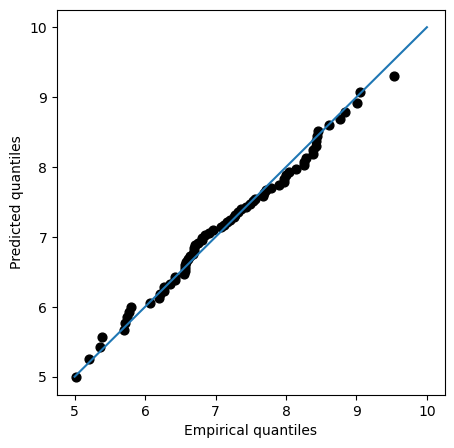

In [13]:
#Defining the function for the empirical cumulative distribution function
def calculate_ecdf(data):
    sorted_data = np.sort(data) 
    n_data = sorted_data.size 
    p_data = np.arange(1, n_data+1) / (n_data +1)
    ecdf = pd.DataFrame({'F_x':p_data, 'significant_wave_height_(m)':sorted_data})
    return ecdf

#Using the function
ecdf_BM = calculate_ecdf(BM_maxima['significant_wave_height_(m)'])

#Extracting the empirical quantiles
empirical_quantiles_BM = ecdf_BM['significant_wave_height_(m)']

#Calculating the quantiles predicted by the fitted distribution
pred_quantiles_GEV = stats.genextreme.ppf(ecdf_BM['F_x'], GEV_param_BM[0], GEV_param_BM[1], GEV_param_BM[2])

#QQplot
plt.figure(8, figsize = (5,5), facecolor='white')
plt.scatter(empirical_quantiles_BM, pred_quantiles_GEV, 40, 'k')
plt.plot([5, 10], [5, 10])
plt.xlabel('Empirical quantiles')
plt.ylabel('Predicted quantiles')

<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
 <b>Solution 7:</b>
    
QQplot compares the measured and predicted quantiles given by our fit. Therefore, the perfect fit
would be the 45-degrees line. In the plot, we can see that the fit is actually very close to that line even
for high values of the variable, suggesting that our model is properly modelling the tails.
 </p>
</div>

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
    
<b>Task 8:</b>
Plot the return level plot and determine the value of the significant wave height that you need for design according to your calculated return period. Remember that return level plot presents in the x-axis the values of the variable (wave height, here) and in the y-axis the corresponding values of the return period. 
    
*Hint: check the definition of return period, it is very easy!*
</p>
</div>

The design value of Hs using the Block Maxima & GEV approach is 9.74 m


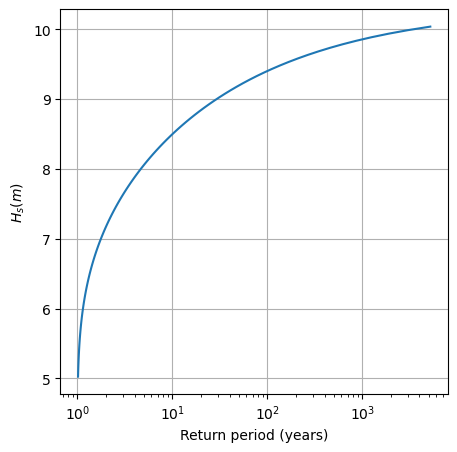

In [14]:
#Creating a linspace of the values of Hs and evaluating their non-exceedance probability (cdf)
x = np.linspace(min(BM_maxima['significant_wave_height_(m)']), max(BM_maxima['significant_wave_height_(m)']+0.5),100)
pred_p_BM = stats.genextreme.cdf(x, GEV_param_BM[0], GEV_param_BM[1], GEV_param_BM[2])

#Calculating the return period
RT_BM = 1/(1-pred_p_BM)

#Plotting (it is common practice to plot return periods or exceedance probabilities in log-scale)
plt.figure(8, figsize = (5,5), facecolor='white')
plt.plot(RT_BM, x)
plt.xscale('log')
plt.ylabel('${H_s (m)}$')
plt.xlabel('Return period (years)')
plt.grid()

#Determining the design value for RT = 475 years
RT_design = 475
p_non_exceed = 1-(1/RT_design) #non-exceedance probability
design_value_BM = stats.genextreme.ppf(p_non_exceed, GEV_param_BM[0], GEV_param_BM[1], GEV_param_BM[2])
print("The design value of Hs using the Block Maxima & GEV approach is", round(design_value_BM, 2), "m")

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
    
<b>Task 9:</b>
Apply POT to sample the extreme observations. Plot the results.
    
Use a threshold of 5 meters and a declustering time of 72h.
</p>
</div>

<div style="background-color:#F9E076; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
Here the solutions are provided using PyExtremes package. You are not required to know who to use it, but you should be able to interpret the results of the analysis.
</p>
</div>

In [15]:
#Import packages and prepare your data
from pyextremes import plot_parameter_stability
from pyextremes.plotting import plot_extremes
from pyextremes import EVA
from pyextremes import get_extremes
from pyextremes import plot_threshold_stability
data = pd.DataFrame(
    {'Date-Time (GMT)':pandas_angle['date_&_time'],
     'Significant_wave_height (m)':pandas_angle['significant_wave_height_(m)']
    }).set_index('Date-Time (GMT)')
data = data.squeeze()

(<Figure size 768x480 with 1 Axes>,
 <Axes: xlabel='Date-Time (GMT)', ylabel='Significant_wave_height (m)'>)

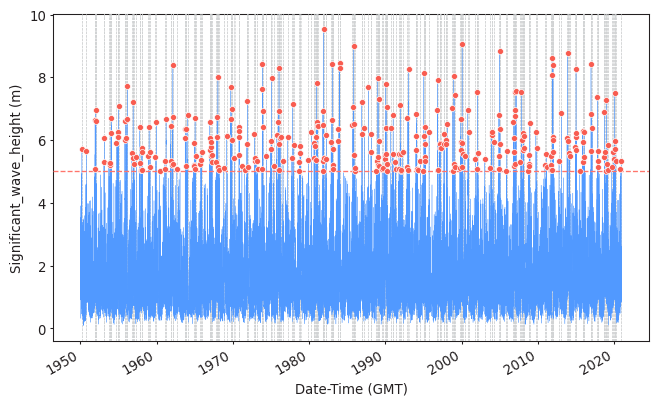

In [16]:
#Extracting the extremes using POT
model = EVA(data=data)
model.get_extremes(
    method="POT",
    extremes_type="high",
    threshold = 5, 
    r = "72H")
#Plotting them
plot_extremes(
    ts=data,
    extremes = model.extremes,
    extremes_method="POT",
    extremes_type="high",
    threshold=5,
    r="72H",
)

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
    
<b>Task 10:</b>
Fit the sampled extremes to fit a Generalized Pareto distribution. Print the shape parameter. What type of GPD are you obtaining?
</p>
</div>

In [17]:
#Fitting the distribution and printing the fitting features
model.fit_model(
    model = "MLE",
    distribution = "genpareto")
print(model.model)

              MLE model               
--------------------------------------
free parameters: c=-0.159, scale=1.206
fixed parameters: floc=5.000          
AIC: 709.530                          
loglikelihood: -352.747               
return value cache size: 0            
fit parameter cache size: 0           
--------------------------------------


<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
 <b>Solution 10:</b>
    
The obtained parameter is close to 0, so the obtained GPD will be close to an Exponential. Note that there is a fixed parameter: floc=5m. This means that in the fitting process, we need to fix the value of the threshold used in the sampling phase. This is because if we don't do it, we leave to the algorithm to find out which was the threshold used, and it is not always successful. There are two options to do the fitting: (1) fit the GPD to the excesses fixing the location to 0, or (2) fit the GPD to the actual values of the random variable fixing the location to the value of the threshold. Both should work numerically.
 </p>
</div>

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
    
<b>Task 11:</b>
Assess the goodness of fit of the distribution using a QQplot. Comment about the results of the fitting and compare it to those obtained using BM and GEV. Which one would you choose?
</p>
</div>

(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='Significant_wave_height (m)'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='Significant_wave_height (m)', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

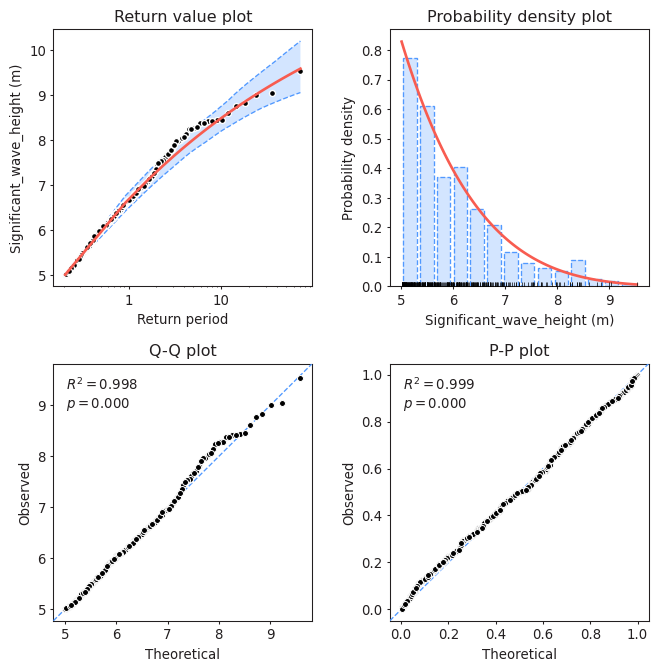

In [18]:
#Assessing goodness of fit
model.plot_diagnostic(alpha=0.95)

<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
 <b>Solution 11:</b>
    
QQplot compares the measured and predicted quantiles given by our fit. Therefore, the perfect fit
would be the 45-degrees line. In the plot, we can see that the fit is actually very close to that line even
for high values of the variable, suggesting that our model is properly modelling the tails.

If we compare it with the fit provided by BM + GEV, we can see that this one is slightly better, since the 
points fluctuate a bit less around the 45-degrees line.
 </p>
</div>

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
    
<b>Task 12:</b>
Plot the return level plot and determine the value of the significant wave height that you need for design according to your calculated return period. Remember that return level plot presents in the x-axis the values of the variable (wave height, here) and in the y-axis the corresponding values of the return period. 

Compare it to the results obtained using BM + GEV.
</p>
</div>

(<Figure size 768x480 with 1 Axes>,
 <Axes: xlabel='Return period', ylabel='Significant_wave_height (m)'>)

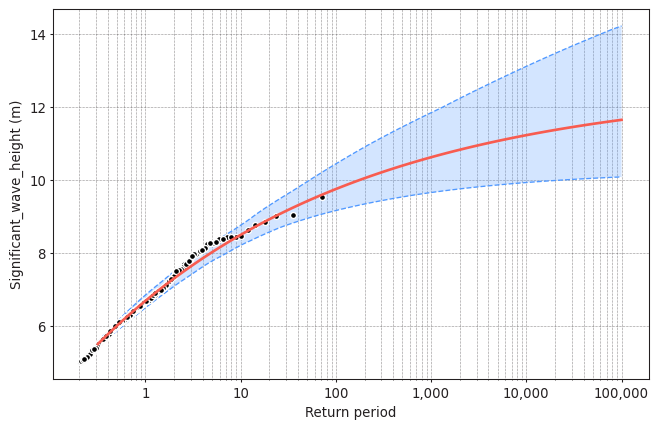

In [19]:
model.plot_return_values(
    return_period=np.logspace(-0.5, 5, 100),
    return_period_size="365.2425D",
    alpha=0.95,
)

In [20]:
design_value = model.get_return_value(
    return_period=475,
    return_period_size="365.2425D",
    alpha = 0.9
)
print(design_value)

(10.374699390221444, 9.67808693594808, 11.202621692002964)


<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
 <b>Solution 12:</b>
    
The obtained design value with BM + GEV was 9.74m.
The obtained design value with POT + GPD is 10.37m.
In this case, POT+GPD is a bit more conservative.
However, this conclusion is case specific and it also depends on the selected threshold and declustering time for 
the POT.
 </p>
</div>

We have performed the analysis with a given threshold = 5m and declustering time = 72h. But are they reasonable? 

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
    
<b>Task 13:</b>
Apply at least one method to justify why a threshold=5m and a declustering time=72h are reasonable or not. Write your conclusions.
</p>
</div>

(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: xlabel='Threshold', ylabel='Modified scale, $\\sigma^*$'>)

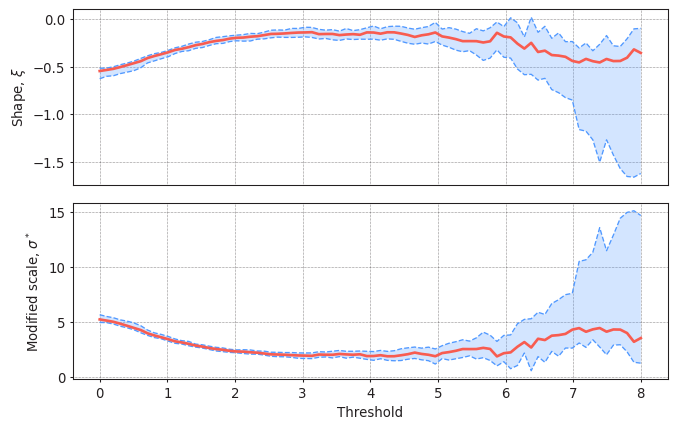

In [21]:
#Plotting the parameter stability plot for a declustering time of 72h
plot_parameter_stability(data, 
                         thresholds = np.linspace(0, 8, 80), 
                         r = "72H",
                         alpha = 0.95)

<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
    <b>Solution 13:</b>
    
Threshold should be selected so the parameters of the GPD remain stable. In this case, thresholds up to 5.5m seem reasonable.
You can perform this analysis with several values of the declustering time.</p>
</div>

<Axes: xlabel='Threshold', ylabel='Mean excess'>

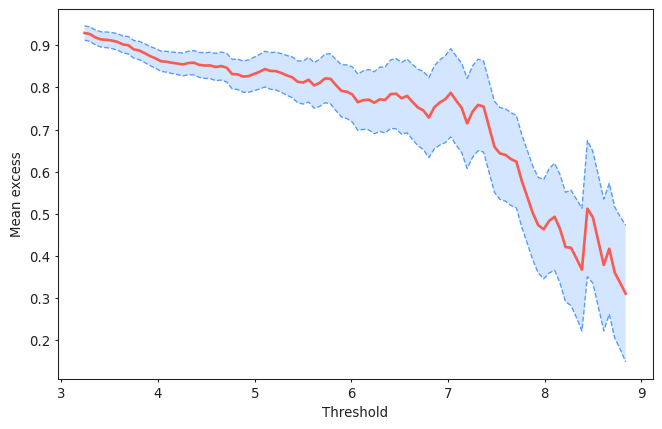

In [22]:
#Plotting the Mean Residual Life plot for a declustering time of 72h 
from pyextremes import plot_mean_residual_life
plot_mean_residual_life(data)

<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Solution 13:</b>
    
Threshold should be selected so the mean excesses follow a linear trend. In this case, thresholds up to 6m seem reasonable.
You can perform this analysis with several values of the declustering time.</p>
</div>

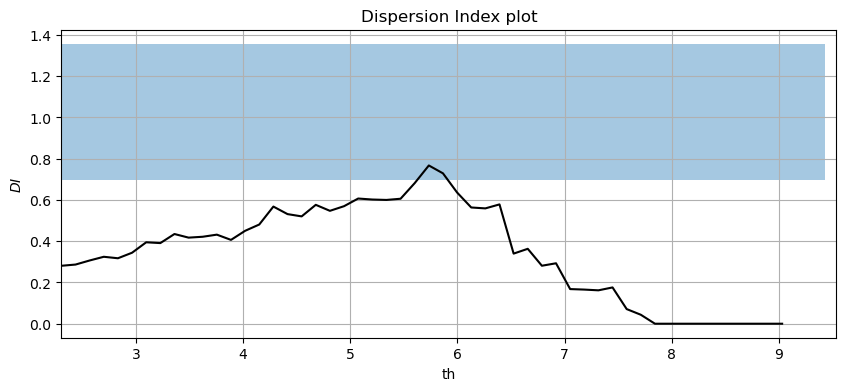

In [23]:
#Plotting the Dispersion Index plot for a declustering time of 72h
#see *.py file for function: DI_plot(dates, data, dl, significance)
DI_plot(pandas_angle['significant_wave_height_(m)'], pandas_angle['date_&_time'], 72, 0.05)

<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Solution 13:</b>
    
Threshold and declustering time should be selected so the Dispersion Index is approximately 1 (within the confidence band) to ensure that the number of excesses per year follows a Poisson distribution. Therefore, thresholds between 5.5 and 6m would be reasonable.</p>
</div>

<div style="background-color:#F9E076; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
Note that there will be some differences between your fitting and that provided by pyExtremes. You have probably defined the declustering time as the time between two extremes (two peaks). PyExtremes defines the declustering time as that between the crossing point over the threshold. The figure below illustrates the diffence.
</p>
</div>

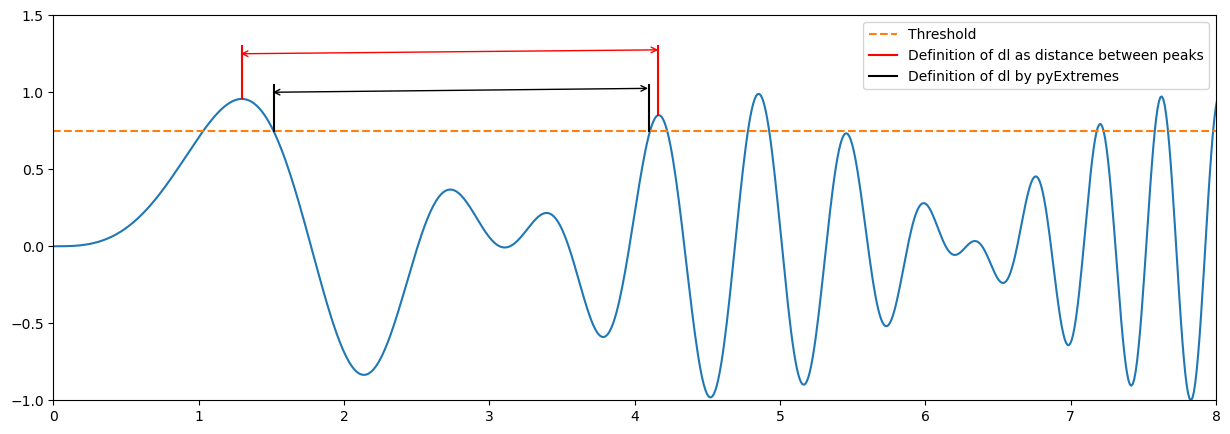

In [24]:
x = np.linspace(0, 10, 1000)
z = np.sin(x**2)
y = z*np.sin(x)

plt.figure(1, figsize = (15,5), facecolor='white')
plt.plot(x, y)
plt.plot([0, 10],[0.75, 0.75], '--', label = 'Threshold')

plt.annotate(' ', xy=(1.27, 1.25), xytext=(4.2, 1.25), arrowprops=dict(arrowstyle='<->', ec = 'r'))
plt.plot([1.3, 1.3],[0.96, 1.3], '-r', label = 'Definition of dl as distance between peaks')
plt.plot([4.16, 4.16],[0.85, 1.3], '-r')
plt.annotate(' ', xy=(1.49, 1), xytext=(4.13, 1), arrowprops=dict(arrowstyle='<->'))
plt.plot([1.52, 1.52],[0.75, 1.05], '-k', label = 'Definition of dl by pyExtremes')
plt.plot([4.1, 4.1],[0.75, 1.05], '-k')
plt.xlim([0, 8])
plt.ylim([-1, 1.5])
plt.legend()

<div style="background-color:#F9E076; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
Based on the above, would you expect more or less sampled extremes using pyExtremes? How would it affect to the calculated lambda?</p>
</div>

<div style="background-color:#ffffe0; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
    
The definition of pyExtremes of dl is more restrictive. Thus, a lower number of extremes will be sampled and lambda will be lower.</p>
</div>

End of notebook.